In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        
        os.path.join(dirname, filename)

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import cv2
from torchvision import datasets,transforms
from glob import glob
import os
from PIL import Image
from matplotlib import patches
from torch.utils.data import Dataset
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torch.utils.data import DataLoader
#Albumentation
import albumentations as al
from albumentations.pytorch.transforms import ToTensorV2

train_dir ='/kaggle/input/global-wheat-detection/train/'
test_dir = '/kaggle/input/global-wheat-detection/test/'
train = pd.read_csv('../input/global-wheat-detection/train.csv') 
weights = '../input/weights/fasterrcnn_resnet50_fpn (1).pth'

In [3]:
sample = pd.read_csv('../input/global-wheat-detection/sample_submission.csv')
sample.shape

(10, 2)

In [4]:
sample

,image_id,PredictionString
0,aac893a91,1.0 0 0 50 50
1,51f1be19e,1.0 0 0 50 50
2,f5a1f0358,1.0 0 0 50 50
3,796707dd7,1.0 0 0 50 50
4,51b3e36ab,1.0 0 0 50 50
5,348a992bb,1.0 0 0 50 50
6,cc3532ff6,1.0 0 0 50 50
7,2fd875eaa,1.0 0 0 50 50
8,cb8d261a3,1.0 0 0 50 50
9,53f253011,1.0 0 0 50 50


In [5]:
class Wheatdatasets(Dataset):
    
    def __init__(self,dataframe,image_dir,transforms = None):
        
        super().__init__()
    
        self.image_id = dataframe['image_id'].unique()
        self.df = dataframe
        self.img_dir = image_dir
        self.transforms = transforms
        
    def __getitem__(self,index:int):
        
        image_id = self.image_id[index]
        record = self.df[self.df['image_id']==image_id]
        
        image = cv2.imread(self.img_dir+image_id+'.jpg',cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB).astype(np.float32)
        image = image/255.0
       
        if self.transforms:
            sample ={
                'image':image
            }
            sample =self.transforms(**sample)
            image = sample['image']
            
            return image,image_id
        
    def __len__(self) -> int:
        return self.image_id.shape[0]

In [6]:
def get_transform():
    return al.Compose([
        ToTensorV2(p=1.0)
    ])

In [7]:
#Create the Model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained = False,pretrained_backbone=False)

In [8]:
device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
num_class = 2 #wheats and background

in_feature = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(in_feature,num_class) #changin the pretrained head with a new one

model.load_state_dict(torch.load(weights))
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample)

In [9]:
x = model.to(device)

In [10]:
def collate_fn(batch):
    return tuple(zip(*batch))


test_dataset = Wheatdatasets(sample,test_dir,get_transform())



test_dataloader = DataLoader(
test_dataset,
batch_size=4,
shuffle =False,
num_workers =4,drop_last = False,
collate_fn = collate_fn)




In [11]:
def format_string(boxes,score):
    pred_strings = []
    for j in zip(score,boxes):
        
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))
        
    return " ".join(pred_strings)
        

In [12]:
detection_threshold = 0.5
results = []

for images, image_ids in test_dataloader:

    images = list(image.to(device) for image in images)
    outputs = model(images)

    for i, image in enumerate(images):

        boxes = outputs[i]['boxes'].data.cpu().numpy()
        scores = outputs[i]['scores'].data.cpu().numpy()
        
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        scores = scores[scores >= detection_threshold]
        image_id = image_ids[i]
        
        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
        
        result = {
            'image_id': image_id,
            'PredictionString': format_string(boxes, scores)
        }

        
        results.append(result)

/opt/conda/lib/python3.7/site-packages/torchvision/ops/boxes.py:101: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629427478/work/torch/csrc/utils/python_arg_parser.cpp:766.)
  keep = keep.nonzero().squeeze(1)


In [13]:
results[:10]

[{'image_id': 'aac893a91',
  'PredictionString': '0.9898 617 914 78 108 0.9895 558 528 121 200 0.9893 74 2 95 165 0.9834 822 708 104 205 0.9832 741 767 80 124 0.9822 694 393 120 186 0.9796 179 565 108 187 0.9789 588 778 96 120 0.9786 29 449 100 169 0.9717 356 531 97 85 0.9712 241 87 136 147 0.9695 548 73 140 183 0.9671 327 660 123 159 0.9656 456 859 87 99 0.9618 304 0 76 65 0.9102 63 855 119 73 0.9087 90 615 123 84 0.9000 232 840 164 112 0.8898 357 257 120 159 0.8657 825 627 84 120 0.8592 440 691 106 95 0.8157 819 918 125 106 0.6311 480 981 93 43 0.5978 626 1 115 132 0.5787 169 5 70 145'},
 {'image_id': '51f1be19e',
  'PredictionString': '0.9857 606 88 169 184 0.9748 0 377 58 106 0.9741 21 0 92 72 0.9714 499 468 210 116 0.9714 838 259 134 213 0.9705 276 475 139 129 0.9677 803 759 110 102 0.9640 811 88 119 85 0.9580 185 928 112 96 0.9568 62 694 141 223 0.9543 766 881 147 103 0.9531 650 789 111 85 0.9372 692 913 90 98 0.9066 769 23 126 72 0.8906 248 119 109 117 0.8903 559 589 124 132 0.8

In [14]:


test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
test_df.head()

,image_id,PredictionString
0,aac893a91,0.9898 617 914 78 108 0.9895 558 528 121 200 0...
1,51f1be19e,0.9857 606 88 169 184 0.9748 0 377 58 106 0.97...
2,f5a1f0358,0.9844 130 750 173 135 0.9834 277 456 178 109 ...
3,796707dd7,0.9738 892 332 119 93 0.9621 0 451 74 78 0.959...
4,51b3e36ab,0.9943 2 435 95 324 0.9932 0 909 85 115 0.9929...


In [15]:
outputs[:4]

[{'boxes': tensor([[  24.1258,  554.6805,  206.5156,  663.8254],
          [  20.4816,  856.9862,  105.2396, 1019.6208],
          [ 748.9212,  707.1546,  837.6289,  794.8181],
          [ 838.4304,  144.6521,  914.0741,  278.7160],
          [ 588.0300,   32.2903,  668.5837,  121.5874],
          [ 433.4347,  118.7336,  543.2731,  194.1339],
          [ 443.5014,  458.9859,  555.1292,  568.5082],
          [ 900.9373,  167.7993, 1000.5187,  292.2943],
          [ 646.8138,  680.5564,  746.0002,  750.9612],
          [   0.0000,  799.0328,   43.2958,  878.3531],
          [ 525.9612,  521.7025,  641.1876,  583.2067],
          [ 314.3544,  147.5663,  418.4150,  373.9238],
          [ 262.4198,  773.1888,  382.3543,  850.4858],
          [ 599.5997,  246.6525,  684.0771,  375.0966],
          [ 797.2562,  217.5923,  864.7083,  324.5314],
          [ 167.2087,  900.7939,  258.5479,  986.9423],
          [ 686.6705,  115.2167,  770.2852,  281.6401],
          [ 516.8188,  259.5104,  603.4

In [16]:
sample = images[0].permute(1,2,0).cpu().numpy()
boxes = outputs[0]['boxes'].data.cpu().numpy()
score = outputs[0]['scores'].data.cpu().numpy()

boxes = boxes[score >= detection_threshold].astype(np.int32)

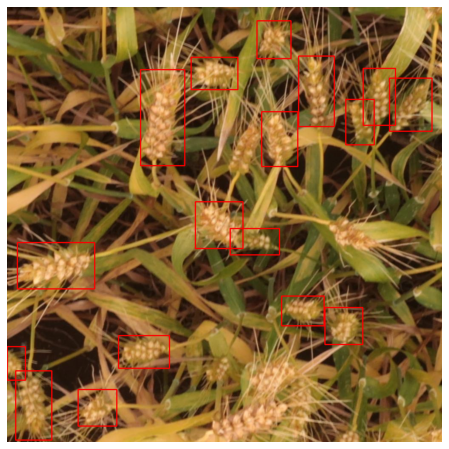

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 2)
    
ax.set_axis_off()
ax.imshow(sample)

In [18]:
sample = images[1].permute(1,2,0).cpu().numpy()
boxes = outputs[1]['boxes'].data.cpu().numpy()
score = outputs[1]['scores'].data.cpu().numpy()

boxes = boxes[score >= detection_threshold].astype(np.int32)

In [19]:
test_df.to_csv('submission.csv', index=False)